In [ ]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizerFast, BertModel
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt
from torchnlp.datasets import imdb_dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
with open("train.pkl", 'rb') as f:
    s_train,y_train =pickle.load(f)
with open("test.pkl", 'rb') as f:
    s_val,y_val =pickle.load(f)

In [5]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
encodings = tokenizer(s_train, add_special_tokens=True, padding=False, truncation=False)
lengths = [len(seq) for seq in encodings["input_ids"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors


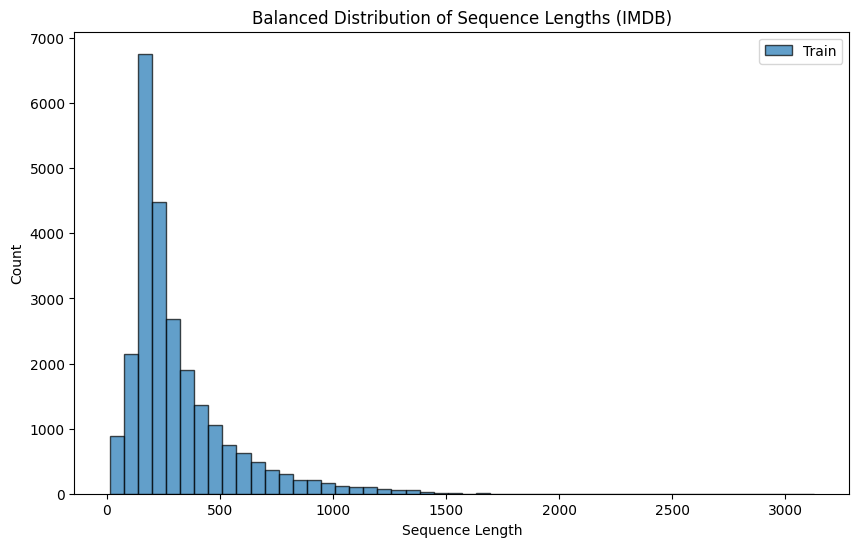

In [6]:
plt.figure(figsize=(10,6))
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7, label='Train')
plt.title('Balanced Distribution of Sequence Lengths (IMDB)')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.legend()
plt.show()

balance

Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1127 > 512). Running this sequence through the model will result in indexing errors


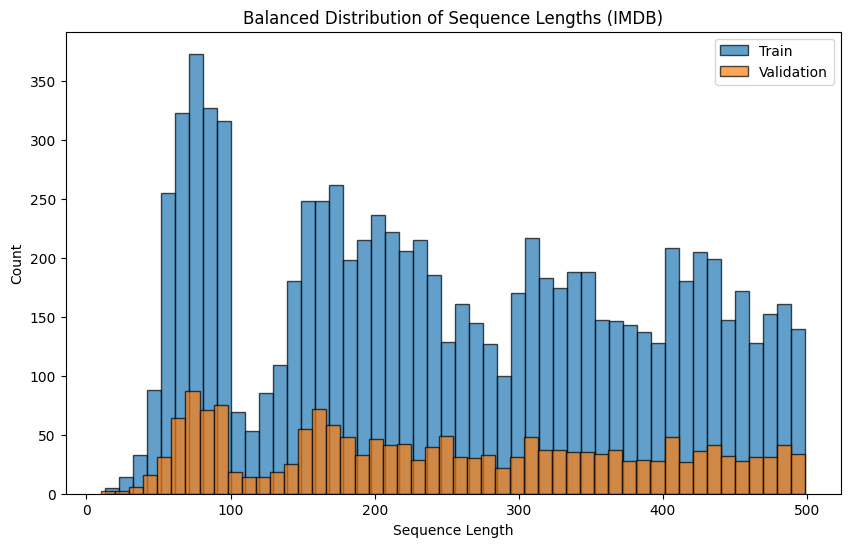

In [7]:
import random

def process_and_balance_dataset(sentences, labels, truncations, seed=42):
    random.seed(seed)

    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
    encodings = tokenizer(sentences, add_special_tokens=True, padding=False, truncation=False)
    lengths = [len(seq) for seq in encodings["input_ids"]]

    bins = [0] + truncations
    bin_indices = {i: [] for i in range(len(bins) - 1)}

    for i, seq_len in enumerate(lengths):
        for b in range(len(bins) - 1):
            if bins[b] <= seq_len < bins[b+1]:
                bin_indices[b].append(i)
                break

    non_empty_bin_sizes = [len(idxs) for idxs in bin_indices.values() if len(idxs) > 0]
    if len(non_empty_bin_sizes) == 0:
        return sentences, labels, lengths

    min_count = min(non_empty_bin_sizes)

    sampled_indices = []
    for b, idxs in bin_indices.items():
        if len(idxs) >= min_count:
            sampled_indices.extend(random.sample(idxs, min_count))  # 受 `seed` 控制
        else:
            sampled_indices.extend(idxs)

    balanced_sentences = [sentences[i] for i in sampled_indices]
    balanced_labels = [labels[i] for i in sampled_indices]
    balanced_lengths = [lengths[i] for i in sampled_indices]

    return balanced_sentences, balanced_labels, balanced_lengths


truncations = [100,200,300,400,500]

balanced_s_train, balanced_y_train, balanced_train_lengths = process_and_balance_dataset(s_train, y_train, truncations)
balanced_s_val, balanced_y_val, balanced_val_lengths = process_and_balance_dataset(s_val, y_val, truncations)

plt.figure(figsize=(10,6))
plt.hist(balanced_train_lengths, bins=50, edgecolor='black', alpha=0.7, label='Train')
plt.hist(balanced_val_lengths, bins=50, edgecolor='black', alpha=0.7, label='Validation')
plt.title('Balanced Distribution of Sequence Lengths (IMDB)')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.legend()
plt.show()


truncation

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Auto-reload (only works in Jupyter Notebook)
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizerFast, BertModel
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt
from collections import Counter

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# -------------------------------
# Load data
with open("train.pkl", 'rb') as f:
    s_train, y_train = pickle.load(f)
with open("test.pkl", 'rb') as f:
    s_val, y_val = pickle.load(f)

# -------------------------------
# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)

# -------------------------------
# Count token lengths in the training set (including special tokens)
encodings = tokenizer(s_train, add_special_tokens=True, padding=False, truncation=False)
lengths = [len(seq) for seq in encodings["input_ids"]]

# Plot histogram of token lengths in the training set
plt.figure(figsize=(10,6))
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7, label='Train')
plt.title('Balanced Distribution of Sequence Lengths (IMDB)')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.legend()
plt.show()

# -------------------------------
# Dynamic window selection:
# Centered on the most frequent sequence length, expand outwards
# until the proportion of data within the window reaches at least 20%
length_counter = Counter(lengths)
most_common_length, count_most_common = length_counter.most_common(1)[0]
print(f"Most common sequence length: {most_common_length} (appears {count_most_common} times)")

desired_fraction = 0.4  # Retain at least 40% of the data
delta = 0
total_samples = len(lengths)
while True:
    lower_bound_candidate = most_common_length - delta
    upper_bound_candidate = most_common_length + delta
    count_in_window = sum(1 for l in lengths if lower_bound_candidate <= l <= upper_bound_candidate)
    fraction = count_in_window / total_samples
    if fraction >= desired_fraction:
        break
    delta += 1

target_lower = most_common_length - delta
target_upper = most_common_length + delta
print(f"Selected window: [{target_lower}, {target_upper}] tokens (delta = {delta}), proportion retained: {fraction:.2%}")

# -------------------------------
# Data augmentation (random truncation)
# Define truncation levels: 20%, 40%, 60%, 80%, 100%
trunc_levels = [0.2, 0.4, 0.6, 0.8, 1]

def augment_sentence(sentence, tokenizer, levels):
    """
    Data augmentation for a sentence:
      1. Tokenize the sentence (without adding special tokens); L = number of tokens.
      2. Randomly select a truncation level (e.g., 0.2, 0.4, 0.6, 0.8).
      3. Calculate window size: window_length = max(1, round(level * L)).
      4. Randomly select a start index and get a continuous span of tokens.
      5. Convert tokens back to string and return the augmented sentence and the level used.
    """
    tokens = tokenizer.tokenize(sentence)
    L = len(tokens)
    if L == 0:
        return sentence, None  # Skip empty sentences
    
    level = random.choice(levels)
    window_length = max(1, int(round(level * L)))
    
    if window_length >= L:
        return sentence, level

    start_idx = random.randint(0, L - window_length)
    truncated_tokens = tokens[start_idx:start_idx + window_length]

    augmented_sentence = tokenizer.convert_tokens_to_string(truncated_tokens)
    return augmented_sentence, level

def filter_and_augment(sentences, labels, tokenizer, lower_bound, upper_bound, levels):
    """
    1. Tokenize each sentence without special tokens.
    2. Filter samples within the specified length range.
    3. Apply random truncation for data augmentation.
    4. Return augmented sentences, labels, and truncation levels.
    """
    augmented_sentences = []
    augmented_labels = []
    truncation_levels_record = []

    for sent, lbl in zip(sentences, labels):
        tokens = tokenizer.tokenize(sent)
        L = len(tokens)
        if lower_bound <= L <= upper_bound:
            aug_sent, level = augment_sentence(sent, tokenizer, levels)
            augmented_sentences.append(aug_sent)
            augmented_labels.append(lbl)
            truncation_levels_record.append(level)
    return augmented_sentences, augmented_labels, truncation_levels_record

# -------------------------------
# Apply filtering and augmentation to both training and validation sets
s_train_aug, y_train_aug, train_trunc_levels = filter_and_augment(
    s_train, y_train, tokenizer, target_lower, target_upper, trunc_levels)
s_val_aug, y_val_aug, val_trunc_levels = filter_and_augment(
    s_val, y_val, tokenizer, target_lower, target_upper, trunc_levels)

print("Training set: Number of filtered and augmented samples =", len(s_train_aug))
print("Validation set: Number of filtered and augmented samples =", len(s_val_aug))

# -------------------------------
# Print class distribution in each dataset
def print_label_ratio(labels, dataset_name):
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n{dataset_name} Total samples: {total}")
    for label, count in counter.items():
        print(f"{label}: {count} ({count/total:.2%})")

print_label_ratio(y_train_aug, "Training Set")
print_label_ratio(y_val_aug, "Validation Set")

# -------------------------------
# Show a few augmented samples
for i in range(min(5, len(s_train_aug))):
    print(f"\nSample {i+1}:")
    print("Original label:", y_train_aug[i])
    print("Truncation level:", train_trunc_levels[i])
    print("Augmented sentence:", s_train_aug[i])


ModuleNotFoundError: No module named 'torch'

## Utile

In [ ]:
# -------------------------------
# Pooling Strategies
def pool_embeddings(embeddings, attention_mask, strategy="cls"):
    if strategy == "cls":
        return embeddings[:, 0, :]
    elif strategy == "mean_with_padding":
        return embeddings.mean(dim=1)
    elif strategy == "mean_without_padding":
        mask = attention_mask.unsqueeze(-1)
        sum_embeddings = (embeddings * mask).sum(dim=1)
        valid_count = mask.sum(dim=1)
        return sum_embeddings / valid_count
    else:
        raise ValueError("Invalid pooling strategy")

# -------------------------------
# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False, save_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        self.save_path = save_path

    def __call__(self, val_loss, model=None):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.save_path and model is not None:
                torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


# -------------------------------
# Full Model
class FullModel(nn.Module):
    def __init__(self, base_model, swe_pooling, classifier, pooling_strategy="swe"):
        super().__init__()
        self.base_model = base_model
        self.swe_pooling = swe_pooling
        self.classifier = classifier
        self.strategy = pooling_strategy

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        if self.strategy == "swe":
            sentence_embeddings = self.swe_pooling(embeddings, mask=attention_mask)
        else:
            sentence_embeddings = pool_embeddings(embeddings, attention_mask, strategy=self.strategy)

        logits = self.classifier(sentence_embeddings)
        return logits

# -------------------------------
# Training

def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss, total_count = 0.0, 0
    with torch.no_grad():
        for batch in data_loader:
            batch = [b.to(device) for b in batch]
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * input_ids.size(0)
            total_count += input_ids.size(0)
    return total_loss / total_count

def train_predict(model, train_loader, val_loader, criterion, optimizer, epochs,
                  scheduler=None, early_stopping=None, device='cpu'):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_count = 0.0, 0

        for batch in train_loader:
            batch = [b.to(device) for b in batch]
            input_ids, attention_mask, labels = batch

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * input_ids.size(0)
            total_train_count += input_ids.size(0)

        train_loss = total_train_loss / total_train_count
        val_loss = evaluate_model(model, val_loader, criterion, device)

        if scheduler is not None:
            scheduler.step(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if early_stopping is not None:
            early_stopping(val_loss, model=model)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break
    return model

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizerFast, BertModel
import pandas as pd
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from collections import Counter

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# -------------------------------
# Data Loading
with open("train.pkl", 'rb') as f:
    s_train, y_train = pickle.load(f)
with open("test.pkl", 'rb') as f:
    s_val, y_val = pickle.load(f)

# -------------------------------
# Tokenizer
... (existing unchanged code) ...

# -------------------------------
# Ensemble Training Function

def run_ensemble_training(s_train, y_train, s_val, y_val,
                          pooling='swe',
                          embedding_size=768,
                          dim_feedforward=1024,
                          epochs=5,
                          learning_rate=2e-5,
                          n_trainings=3,
                          batch_size=32,
                          max_length=100,
                          early_stopping_patience=3,
                          device=None):
    """
    Run ensemble training on BERT + custom pooling. Useful for uncertainty quantification.
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Convert labels from 'neg', 'pos' to 0 and 1
    label_map = {"neg": 0, "pos": 1}
    y_train_int = [label_map[lbl] for lbl in y_train]
    y_val_int   = [label_map[lbl] for lbl in y_val]

    y_train_tensor = torch.tensor(y_train_int, dtype=torch.long)
    y_val_tensor   = torch.tensor(y_val_int,   dtype=torch.long)

    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
    train_encodings = tokenizer(s_train, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    val_encodings   = tokenizer(s_val,   padding=True, truncation=True, max_length=max_length, return_tensors="pt")

    train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], y_train_tensor)
    val_dataset   = TensorDataset(val_encodings["input_ids"],   val_encodings["attention_mask"],   y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

    num_labels = 2
    num_slices = 768
    num_ref_points = 10
    n_samples = len(y_val)

    predictions_df = pd.DataFrame(index=range(n_samples), columns=range(n_trainings))

    print(f"\nTraining {n_trainings} models for ensemble to quantify uncertainty.")

    for i in tqdm(range(n_trainings), desc="Ensemble training"):
        base_model = BertModel.from_pretrained("bert-base-uncased").to(device)

        for name, param in base_model.named_parameters():
            param.requires_grad = False

        swe_pooling_layer = SWE_Pooling(
            d_in=base_model.config.hidden_size,
            num_slices=num_slices,
            num_ref_points=num_ref_points,
            freeze_swe=False
        ).to(device)

        if pooling == "swe":
            classifier = nn.Linear(num_slices, num_labels).to(device)
            optimizer = torch.optim.Adam(
                list(swe_pooling_layer.parameters()) + list(classifier.parameters()),
                lr=learning_rate
            )
        else:
            classifier = nn.Linear(base_model.config.hidden_size, num_labels).to(device)
            optimizer = torch.optim.Adam(
                list(classifier.parameters()),
                lr=learning_rate
            )

        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', patience=2, factor=0.1
        )
        early_stopper = EarlyStopping(
            patience=early_stopping_patience, min_delta=0.01
        )

        full_model = FullModel(
            base_model=base_model,
            swe_pooling=swe_pooling_layer,
            classifier=classifier,
            pooling_strategy=pooling
        ).to(device)

        trained_model = train_predict(
            model=full_model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            epochs=epochs,
            scheduler=scheduler,
            early_stopping=early_stopper,
            device=device
        )

        all_probs = []
        trained_model.eval()
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = trained_model(input_ids, attention_mask=attention_mask)
                probs = F.softmax(outputs, dim=1)
                all_probs.append(probs.cpu().numpy())

        probabilities = np.concatenate(all_probs)
        predictions_df[i] = probabilities[:, 1]

    print(f"Shape of predictions_df: {predictions_df.shape}")
    print(f"Sample predictions:\n{predictions_df.head()}")

    if not predictions_df.empty:
        model_dir = f'model'
        os.makedirs(model_dir, exist_ok=True)
        predictions_path = os.path.join(model_dir, f'ntrain_{pooling}_sq{max_length}_imdb_bal.pkl')
        with open(predictions_path, 'wb') as f:
            pickle.dump(predictions_df, f)
        print(f"Predictions saved to {predictions_path}")
    else:
        print("Warning: predictions_df is empty. File not saved.")

    return predictions_df


In [11]:
truncation = [target_upper]  
pooling_strategies = [ "cls",'mean_without_padding']  

for max_l in truncation:
    for pool in pooling_strategies:
        print(f"\n=== Running ensemble training with max_length={max_l}, pooling={pool} ===")
        predictions = run_ensemble_training(
            s_train=s_train_aug,
            y_train=y_train_aug,
            s_val=s_val_aug,
            y_val=y_val_aug,
            pooling=pool,
            embedding_size=768,
            dim_feedforward=1024,
            epochs=50,              
            learning_rate=1e-3,   
            n_trainings=10,        
            batch_size=1024,        
            max_length=max_l,
            early_stopping_patience=3
        )


=== Running ensemble training with max_length=230, pooling=cls ===
Using device: cuda

Training 10 models for ensemble to quantify uncertainty.


Ensemble training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6696, Val Loss: 0.6165
Epoch [2/50], Train Loss: 0.6044, Val Loss: 0.5591
Epoch [3/50], Train Loss: 0.5599, Val Loss: 0.5213
Epoch [4/50], Train Loss: 0.5304, Val Loss: 0.4987
Epoch [5/50], Train Loss: 0.5120, Val Loss: 0.4899
Epoch [6/50], Train Loss: 0.4978, Val Loss: 0.4780
Epoch [7/50], Train Loss: 0.4868, Val Loss: 0.4574
Epoch [8/50], Train Loss: 0.4764, Val Loss: 0.4547
Epoch [9/50], Train Loss: 0.4715, Val Loss: 0.4525
Epoch [10/50], Train Loss: 0.4638, Val Loss: 0.4402
Epoch [11/50], Train Loss: 0.4639, Val Loss: 0.4370
Epoch [12/50], Train Loss: 0.4555, Val Loss: 0.4347
Epoch [13/50], Train Loss: 0.4524, Val Loss: 0.4369
Early stopping triggered.


Ensemble training:  10%|█         | 1/10 [07:09<1:04:24, 429.37s/it]

Epoch [1/50], Train Loss: 0.6676, Val Loss: 0.6159
Epoch [2/50], Train Loss: 0.6039, Val Loss: 0.5603
Epoch [3/50], Train Loss: 0.5591, Val Loss: 0.5198
Epoch [4/50], Train Loss: 0.5305, Val Loss: 0.4938
Epoch [5/50], Train Loss: 0.5123, Val Loss: 0.4779
Epoch [6/50], Train Loss: 0.4960, Val Loss: 0.4708
Epoch [7/50], Train Loss: 0.4848, Val Loss: 0.4640
Epoch [8/50], Train Loss: 0.4743, Val Loss: 0.4528
Epoch [9/50], Train Loss: 0.4734, Val Loss: 0.4456
Epoch [10/50], Train Loss: 0.4621, Val Loss: 0.4383
Epoch [11/50], Train Loss: 0.4608, Val Loss: 0.4383
Epoch [12/50], Train Loss: 0.4569, Val Loss: 0.4309
Epoch [13/50], Train Loss: 0.4530, Val Loss: 0.4287
Early stopping triggered.


Ensemble training:  20%|██        | 2/10 [14:22<57:30, 431.30s/it]  

Epoch [1/50], Train Loss: 0.6655, Val Loss: 0.6100
Epoch [2/50], Train Loss: 0.5957, Val Loss: 0.5471
Epoch [3/50], Train Loss: 0.5521, Val Loss: 0.5099
Epoch [4/50], Train Loss: 0.5236, Val Loss: 0.4898
Epoch [5/50], Train Loss: 0.5036, Val Loss: 0.4743
Epoch [6/50], Train Loss: 0.4909, Val Loss: 0.4629
Epoch [7/50], Train Loss: 0.4786, Val Loss: 0.4538
Epoch [8/50], Train Loss: 0.4720, Val Loss: 0.4463
Epoch [9/50], Train Loss: 0.4648, Val Loss: 0.4466
Epoch [10/50], Train Loss: 0.4624, Val Loss: 0.4465
Epoch [11/50], Train Loss: 0.4548, Val Loss: 0.4364
Early stopping triggered.


Ensemble training:  30%|███       | 3/10 [22:56<54:44, 469.20s/it]

Epoch [1/50], Train Loss: 0.6583, Val Loss: 0.6054
Epoch [2/50], Train Loss: 0.5963, Val Loss: 0.5468
Epoch [3/50], Train Loss: 0.5513, Val Loss: 0.5121
Epoch [4/50], Train Loss: 0.5242, Val Loss: 0.4879
Epoch [5/50], Train Loss: 0.5040, Val Loss: 0.4684
Epoch [6/50], Train Loss: 0.4891, Val Loss: 0.4571
Epoch [7/50], Train Loss: 0.4805, Val Loss: 0.4489
Epoch [8/50], Train Loss: 0.4718, Val Loss: 0.4458
Epoch [9/50], Train Loss: 0.4670, Val Loss: 0.4422
Epoch [10/50], Train Loss: 0.4603, Val Loss: 0.4353
Epoch [11/50], Train Loss: 0.4571, Val Loss: 0.4301
Epoch [12/50], Train Loss: 0.4564, Val Loss: 0.4294
Epoch [13/50], Train Loss: 0.4497, Val Loss: 0.4315
Early stopping triggered.


Ensemble training:  40%|████      | 4/10 [38:20<1:04:52, 648.72s/it]

Epoch [1/50], Train Loss: 0.6539, Val Loss: 0.6058
Epoch [2/50], Train Loss: 0.5920, Val Loss: 0.5536
Epoch [3/50], Train Loss: 0.5526, Val Loss: 0.5199
Epoch [4/50], Train Loss: 0.5241, Val Loss: 0.4912
Epoch [5/50], Train Loss: 0.5042, Val Loss: 0.4748
Epoch [6/50], Train Loss: 0.4926, Val Loss: 0.4674
Epoch [7/50], Train Loss: 0.4830, Val Loss: 0.4619
Epoch [8/50], Train Loss: 0.4751, Val Loss: 0.4483
Epoch [9/50], Train Loss: 0.4698, Val Loss: 0.4452
Epoch [10/50], Train Loss: 0.4622, Val Loss: 0.4394
Epoch [11/50], Train Loss: 0.4563, Val Loss: 0.4349
Epoch [12/50], Train Loss: 0.4553, Val Loss: 0.4344
Epoch [13/50], Train Loss: 0.4538, Val Loss: 0.4320
Epoch [14/50], Train Loss: 0.4502, Val Loss: 0.4405
Early stopping triggered.


Ensemble training:  50%|█████     | 5/10 [54:55<1:04:28, 773.69s/it]

Epoch [1/50], Train Loss: 0.6618, Val Loss: 0.6068
Epoch [2/50], Train Loss: 0.5942, Val Loss: 0.5497
Epoch [3/50], Train Loss: 0.5560, Val Loss: 0.5152
Epoch [4/50], Train Loss: 0.5288, Val Loss: 0.4995
Epoch [5/50], Train Loss: 0.5096, Val Loss: 0.4822
Epoch [6/50], Train Loss: 0.4919, Val Loss: 0.4665
Epoch [7/50], Train Loss: 0.4833, Val Loss: 0.4615
Epoch [8/50], Train Loss: 0.4754, Val Loss: 0.4471
Epoch [9/50], Train Loss: 0.4699, Val Loss: 0.4428
Epoch [10/50], Train Loss: 0.4633, Val Loss: 0.4404
Epoch [11/50], Train Loss: 0.4615, Val Loss: 0.4344
Epoch [12/50], Train Loss: 0.4598, Val Loss: 0.4330
Epoch [13/50], Train Loss: 0.4531, Val Loss: 0.4271
Epoch [14/50], Train Loss: 0.4484, Val Loss: 0.4279
Early stopping triggered.


Ensemble training:  60%|██████    | 6/10 [1:11:29<56:34, 848.53s/it]

Epoch [1/50], Train Loss: 0.6697, Val Loss: 0.6113
Epoch [2/50], Train Loss: 0.6012, Val Loss: 0.5518
Epoch [3/50], Train Loss: 0.5585, Val Loss: 0.5147
Epoch [4/50], Train Loss: 0.5250, Val Loss: 0.4890
Epoch [5/50], Train Loss: 0.5071, Val Loss: 0.4735
Epoch [6/50], Train Loss: 0.4914, Val Loss: 0.4660
Epoch [7/50], Train Loss: 0.4802, Val Loss: 0.4563
Epoch [8/50], Train Loss: 0.4744, Val Loss: 0.4486
Epoch [9/50], Train Loss: 0.4677, Val Loss: 0.4415
Epoch [10/50], Train Loss: 0.4640, Val Loss: 0.4333
Epoch [11/50], Train Loss: 0.4563, Val Loss: 0.4411
Epoch [12/50], Train Loss: 0.4543, Val Loss: 0.4317
Early stopping triggered.


Ensemble training:  70%|███████   | 7/10 [1:25:42<42:30, 850.04s/it]

Epoch [1/50], Train Loss: 0.6564, Val Loss: 0.6007
Epoch [2/50], Train Loss: 0.5908, Val Loss: 0.5414
Epoch [3/50], Train Loss: 0.5451, Val Loss: 0.5114
Epoch [4/50], Train Loss: 0.5200, Val Loss: 0.4888
Epoch [5/50], Train Loss: 0.5003, Val Loss: 0.4700
Epoch [6/50], Train Loss: 0.4884, Val Loss: 0.4571
Epoch [7/50], Train Loss: 0.4773, Val Loss: 0.4500
Epoch [8/50], Train Loss: 0.4728, Val Loss: 0.4465
Epoch [9/50], Train Loss: 0.4645, Val Loss: 0.4400
Epoch [10/50], Train Loss: 0.4599, Val Loss: 0.4333
Epoch [11/50], Train Loss: 0.4591, Val Loss: 0.4336
Epoch [12/50], Train Loss: 0.4551, Val Loss: 0.4285
Epoch [13/50], Train Loss: 0.4534, Val Loss: 0.4237
Early stopping triggered.


Ensemble training:  80%|████████  | 8/10 [1:41:07<29:07, 873.94s/it]

Epoch [1/50], Train Loss: 0.6661, Val Loss: 0.6173
Epoch [2/50], Train Loss: 0.6043, Val Loss: 0.5627
Epoch [3/50], Train Loss: 0.5604, Val Loss: 0.5208
Epoch [4/50], Train Loss: 0.5318, Val Loss: 0.4955
Epoch [5/50], Train Loss: 0.5135, Val Loss: 0.4791
Epoch [6/50], Train Loss: 0.4950, Val Loss: 0.4671
Epoch [7/50], Train Loss: 0.4848, Val Loss: 0.4628
Epoch [8/50], Train Loss: 0.4811, Val Loss: 0.4533
Epoch [9/50], Train Loss: 0.4716, Val Loss: 0.4421
Epoch [10/50], Train Loss: 0.4660, Val Loss: 0.4402
Epoch [11/50], Train Loss: 0.4611, Val Loss: 0.4415
Epoch [12/50], Train Loss: 0.4563, Val Loss: 0.4288
Epoch [13/50], Train Loss: 0.4565, Val Loss: 0.4242
Epoch [14/50], Train Loss: 0.4512, Val Loss: 0.4289
Epoch [15/50], Train Loss: 0.4512, Val Loss: 0.4338
Early stopping triggered.


Ensemble training:  90%|█████████ | 9/10 [1:58:52<15:33, 933.66s/it]

Epoch [1/50], Train Loss: 0.6756, Val Loss: 0.6307
Epoch [2/50], Train Loss: 0.6158, Val Loss: 0.5778
Epoch [3/50], Train Loss: 0.5702, Val Loss: 0.5309
Epoch [4/50], Train Loss: 0.5390, Val Loss: 0.5052
Epoch [5/50], Train Loss: 0.5160, Val Loss: 0.4877
Epoch [6/50], Train Loss: 0.5028, Val Loss: 0.4736
Epoch [7/50], Train Loss: 0.4900, Val Loss: 0.4622
Epoch [8/50], Train Loss: 0.4809, Val Loss: 0.4556
Epoch [9/50], Train Loss: 0.4712, Val Loss: 0.4490
Epoch [10/50], Train Loss: 0.4661, Val Loss: 0.4417
Epoch [11/50], Train Loss: 0.4636, Val Loss: 0.4368
Epoch [12/50], Train Loss: 0.4586, Val Loss: 0.4361
Epoch [13/50], Train Loss: 0.4544, Val Loss: 0.4290
Epoch [14/50], Train Loss: 0.4553, Val Loss: 0.4291
Early stopping triggered.


Ensemble training: 100%|██████████| 10/10 [2:15:28<00:00, 812.82s/it]


Shape of predictions_df: (2028, 10)
Sample predictions:
          0         1         2         3         4         5         6  \
0  0.809826  0.799509  0.810550  0.833596  0.841133  0.819172  0.812466   
1  0.100965  0.088818  0.090567  0.086874  0.102282  0.089771  0.089607   
2  0.531233  0.475319  0.517922  0.527212  0.551481  0.461107  0.489545   
3  0.730699  0.703977  0.738027  0.753391  0.749889  0.753546  0.703665   
4  0.507178  0.480081  0.496075  0.495243  0.553731  0.498373  0.491461   

          7         8         9  
0  0.811944  0.821970  0.819349  
1  0.082744  0.102065  0.091292  
2  0.455782  0.527430  0.497440  
3  0.705174  0.761397  0.723570  
4  0.440470  0.527127  0.457911  
Predictions saved to model/ntrain_cls_sq230_imdb_bal.pkl

=== Running ensemble training with max_length=230, pooling=mean_without_padding ===
Using device: cuda

Training 10 models for ensemble to quantify uncertainty.


Ensemble training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 0.6662, Val Loss: 0.6275
Epoch [2/50], Train Loss: 0.6087, Val Loss: 0.5751
Epoch [3/50], Train Loss: 0.5649, Val Loss: 0.5389
Epoch [4/50], Train Loss: 0.5321, Val Loss: 0.5074
Epoch [5/50], Train Loss: 0.5083, Val Loss: 0.4882
Epoch [6/50], Train Loss: 0.4905, Val Loss: 0.4699
Epoch [7/50], Train Loss: 0.4758, Val Loss: 0.4573
Epoch [8/50], Train Loss: 0.4631, Val Loss: 0.4489
Epoch [9/50], Train Loss: 0.4541, Val Loss: 0.4393
Epoch [10/50], Train Loss: 0.4456, Val Loss: 0.4304
Epoch [11/50], Train Loss: 0.4408, Val Loss: 0.4252
Epoch [12/50], Train Loss: 0.4343, Val Loss: 0.4203
Epoch [13/50], Train Loss: 0.4297, Val Loss: 0.4144
Epoch [14/50], Train Loss: 0.4279, Val Loss: 0.4079
Epoch [15/50], Train Loss: 0.4241, Val Loss: 0.4083
Epoch [16/50], Train Loss: 0.4194, Val Loss: 0.4056
Early stopping triggered.


Ensemble training:  10%|█         | 1/10 [18:57<2:50:41, 1137.93s/it]

Epoch [1/50], Train Loss: 0.6628, Val Loss: 0.6246
Epoch [2/50], Train Loss: 0.6065, Val Loss: 0.5794
Epoch [3/50], Train Loss: 0.5662, Val Loss: 0.5396
Epoch [4/50], Train Loss: 0.5347, Val Loss: 0.5084
Epoch [5/50], Train Loss: 0.5100, Val Loss: 0.4891
Epoch [6/50], Train Loss: 0.4925, Val Loss: 0.4730
Epoch [7/50], Train Loss: 0.4786, Val Loss: 0.4619
Epoch [8/50], Train Loss: 0.4672, Val Loss: 0.4517
Epoch [9/50], Train Loss: 0.4591, Val Loss: 0.4388
Epoch [10/50], Train Loss: 0.4502, Val Loss: 0.4355
Epoch [11/50], Train Loss: 0.4435, Val Loss: 0.4279
Epoch [12/50], Train Loss: 0.4379, Val Loss: 0.4250
Epoch [13/50], Train Loss: 0.4338, Val Loss: 0.4190
Epoch [14/50], Train Loss: 0.4292, Val Loss: 0.4135
Epoch [15/50], Train Loss: 0.4239, Val Loss: 0.4086
Epoch [16/50], Train Loss: 0.4225, Val Loss: 0.4056
Epoch [17/50], Train Loss: 0.4205, Val Loss: 0.4063
Early stopping triggered.


Ensemble training:  20%|██        | 2/10 [39:04<2:37:05, 1178.15s/it]

Epoch [1/50], Train Loss: 0.6816, Val Loss: 0.6494
Epoch [2/50], Train Loss: 0.6304, Val Loss: 0.6068
Epoch [3/50], Train Loss: 0.5902, Val Loss: 0.5634
Epoch [4/50], Train Loss: 0.5561, Val Loss: 0.5345
Epoch [5/50], Train Loss: 0.5307, Val Loss: 0.5101
Epoch [6/50], Train Loss: 0.5095, Val Loss: 0.4927
Epoch [7/50], Train Loss: 0.4940, Val Loss: 0.4740
Epoch [8/50], Train Loss: 0.4798, Val Loss: 0.4645
Epoch [9/50], Train Loss: 0.4693, Val Loss: 0.4551
Epoch [10/50], Train Loss: 0.4602, Val Loss: 0.4428
Epoch [11/50], Train Loss: 0.4528, Val Loss: 0.4379
Epoch [12/50], Train Loss: 0.4443, Val Loss: 0.4304
Epoch [13/50], Train Loss: 0.4386, Val Loss: 0.4242
Epoch [14/50], Train Loss: 0.4348, Val Loss: 0.4213
Epoch [15/50], Train Loss: 0.4309, Val Loss: 0.4170
Epoch [16/50], Train Loss: 0.4256, Val Loss: 0.4123
Epoch [17/50], Train Loss: 0.4220, Val Loss: 0.4097
Epoch [18/50], Train Loss: 0.4204, Val Loss: 0.4057
Epoch [19/50], Train Loss: 0.4170, Val Loss: 0.4026
Epoch [20/50], Train 

Ensemble training:  30%|███       | 3/10 [1:03:53<2:34:02, 1320.40s/it]

Epoch [1/50], Train Loss: 0.6685, Val Loss: 0.6320
Epoch [2/50], Train Loss: 0.6120, Val Loss: 0.5800
Epoch [3/50], Train Loss: 0.5682, Val Loss: 0.5403
Epoch [4/50], Train Loss: 0.5352, Val Loss: 0.5109
Epoch [5/50], Train Loss: 0.5107, Val Loss: 0.4879
Epoch [6/50], Train Loss: 0.4914, Val Loss: 0.4708
Epoch [7/50], Train Loss: 0.4771, Val Loss: 0.4633
Epoch [8/50], Train Loss: 0.4651, Val Loss: 0.4481
Epoch [9/50], Train Loss: 0.4575, Val Loss: 0.4381
Epoch [10/50], Train Loss: 0.4491, Val Loss: 0.4305
Epoch [11/50], Train Loss: 0.4431, Val Loss: 0.4277
Epoch [12/50], Train Loss: 0.4368, Val Loss: 0.4195
Epoch [13/50], Train Loss: 0.4308, Val Loss: 0.4155
Epoch [14/50], Train Loss: 0.4270, Val Loss: 0.4086
Epoch [15/50], Train Loss: 0.4260, Val Loss: 0.4103
Epoch [16/50], Train Loss: 0.4222, Val Loss: 0.4099
Epoch [17/50], Train Loss: 0.4184, Val Loss: 0.4006
Early stopping triggered.


Ensemble training:  40%|████      | 4/10 [1:18:26<1:54:21, 1143.52s/it]

Epoch [1/50], Train Loss: 0.6734, Val Loss: 0.6372
Epoch [2/50], Train Loss: 0.6205, Val Loss: 0.5880
Epoch [3/50], Train Loss: 0.5769, Val Loss: 0.5490
Epoch [4/50], Train Loss: 0.5452, Val Loss: 0.5180
Epoch [5/50], Train Loss: 0.5192, Val Loss: 0.4957
Epoch [6/50], Train Loss: 0.5006, Val Loss: 0.4817
Epoch [7/50], Train Loss: 0.4834, Val Loss: 0.4625
Epoch [8/50], Train Loss: 0.4696, Val Loss: 0.4527
Epoch [9/50], Train Loss: 0.4612, Val Loss: 0.4459
Epoch [10/50], Train Loss: 0.4516, Val Loss: 0.4334
Epoch [11/50], Train Loss: 0.4475, Val Loss: 0.4293
Epoch [12/50], Train Loss: 0.4396, Val Loss: 0.4244
Epoch [13/50], Train Loss: 0.4351, Val Loss: 0.4174
Epoch [14/50], Train Loss: 0.4309, Val Loss: 0.4127
Epoch [15/50], Train Loss: 0.4250, Val Loss: 0.4098
Epoch [16/50], Train Loss: 0.4218, Val Loss: 0.4075
Early stopping triggered.


Ensemble training:  50%|█████     | 5/10 [1:27:19<1:16:57, 923.49s/it] 

Epoch [1/50], Train Loss: 0.6681, Val Loss: 0.6289
Epoch [2/50], Train Loss: 0.6119, Val Loss: 0.5768
Epoch [3/50], Train Loss: 0.5679, Val Loss: 0.5374
Epoch [4/50], Train Loss: 0.5349, Val Loss: 0.5099
Epoch [5/50], Train Loss: 0.5107, Val Loss: 0.4905
Epoch [6/50], Train Loss: 0.4915, Val Loss: 0.4689
Epoch [7/50], Train Loss: 0.4776, Val Loss: 0.4586
Epoch [8/50], Train Loss: 0.4658, Val Loss: 0.4487
Epoch [9/50], Train Loss: 0.4552, Val Loss: 0.4409
Epoch [10/50], Train Loss: 0.4485, Val Loss: 0.4315
Epoch [11/50], Train Loss: 0.4418, Val Loss: 0.4225
Epoch [12/50], Train Loss: 0.4360, Val Loss: 0.4216
Epoch [13/50], Train Loss: 0.4316, Val Loss: 0.4181
Epoch [14/50], Train Loss: 0.4292, Val Loss: 0.4107
Epoch [15/50], Train Loss: 0.4245, Val Loss: 0.4046
Epoch [16/50], Train Loss: 0.4213, Val Loss: 0.4059
Epoch [17/50], Train Loss: 0.4175, Val Loss: 0.4063
Early stopping triggered.


Ensemble training:  60%|██████    | 6/10 [1:36:45<53:27, 801.82s/it]  

Epoch [1/50], Train Loss: 0.6682, Val Loss: 0.6328
Epoch [2/50], Train Loss: 0.6149, Val Loss: 0.5852
Epoch [3/50], Train Loss: 0.5734, Val Loss: 0.5454
Epoch [4/50], Train Loss: 0.5419, Val Loss: 0.5173
Epoch [5/50], Train Loss: 0.5165, Val Loss: 0.4964
Epoch [6/50], Train Loss: 0.4977, Val Loss: 0.4763
Epoch [7/50], Train Loss: 0.4822, Val Loss: 0.4637
Epoch [8/50], Train Loss: 0.4687, Val Loss: 0.4544
Epoch [9/50], Train Loss: 0.4596, Val Loss: 0.4419
Epoch [10/50], Train Loss: 0.4517, Val Loss: 0.4371
Epoch [11/50], Train Loss: 0.4437, Val Loss: 0.4333
Epoch [12/50], Train Loss: 0.4396, Val Loss: 0.4206
Epoch [13/50], Train Loss: 0.4335, Val Loss: 0.4171
Epoch [14/50], Train Loss: 0.4290, Val Loss: 0.4134
Epoch [15/50], Train Loss: 0.4247, Val Loss: 0.4102
Epoch [16/50], Train Loss: 0.4207, Val Loss: 0.4086
Epoch [17/50], Train Loss: 0.4192, Val Loss: 0.4012
Epoch [18/50], Train Loss: 0.4143, Val Loss: 0.4019
Early stopping triggered.


Ensemble training:  70%|███████   | 7/10 [1:46:44<36:46, 735.50s/it]

Epoch [1/50], Train Loss: 0.6700, Val Loss: 0.6365
Epoch [2/50], Train Loss: 0.6201, Val Loss: 0.5882
Epoch [3/50], Train Loss: 0.5795, Val Loss: 0.5501
Epoch [4/50], Train Loss: 0.5478, Val Loss: 0.5229
Epoch [5/50], Train Loss: 0.5224, Val Loss: 0.4994
Epoch [6/50], Train Loss: 0.5035, Val Loss: 0.4816
Epoch [7/50], Train Loss: 0.4872, Val Loss: 0.4679
Epoch [8/50], Train Loss: 0.4739, Val Loss: 0.4568
Epoch [9/50], Train Loss: 0.4644, Val Loss: 0.4472
Epoch [10/50], Train Loss: 0.4563, Val Loss: 0.4379
Epoch [11/50], Train Loss: 0.4476, Val Loss: 0.4330
Epoch [12/50], Train Loss: 0.4429, Val Loss: 0.4284
Epoch [13/50], Train Loss: 0.4384, Val Loss: 0.4201
Epoch [14/50], Train Loss: 0.4321, Val Loss: 0.4202
Epoch [15/50], Train Loss: 0.4281, Val Loss: 0.4177
Epoch [16/50], Train Loss: 0.4263, Val Loss: 0.4087
Epoch [17/50], Train Loss: 0.4212, Val Loss: 0.4038
Epoch [18/50], Train Loss: 0.4211, Val Loss: 0.4060
Epoch [19/50], Train Loss: 0.4159, Val Loss: 0.3982
Epoch [20/50], Train 

Ensemble training:  80%|████████  | 8/10 [1:58:54<24:27, 733.76s/it]

Epoch [1/50], Train Loss: 0.6630, Val Loss: 0.6264
Epoch [2/50], Train Loss: 0.6066, Val Loss: 0.5751
Epoch [3/50], Train Loss: 0.5641, Val Loss: 0.5363
Epoch [4/50], Train Loss: 0.5328, Val Loss: 0.5071
Epoch [5/50], Train Loss: 0.5082, Val Loss: 0.4870
Epoch [6/50], Train Loss: 0.4897, Val Loss: 0.4700
Epoch [7/50], Train Loss: 0.4753, Val Loss: 0.4560
Epoch [8/50], Train Loss: 0.4661, Val Loss: 0.4451
Epoch [9/50], Train Loss: 0.4559, Val Loss: 0.4407
Epoch [10/50], Train Loss: 0.4471, Val Loss: 0.4296
Epoch [11/50], Train Loss: 0.4416, Val Loss: 0.4216
Epoch [12/50], Train Loss: 0.4355, Val Loss: 0.4205
Epoch [13/50], Train Loss: 0.4302, Val Loss: 0.4146
Epoch [14/50], Train Loss: 0.4274, Val Loss: 0.4088
Epoch [15/50], Train Loss: 0.4229, Val Loss: 0.4091
Epoch [16/50], Train Loss: 0.4193, Val Loss: 0.4021
Epoch [17/50], Train Loss: 0.4164, Val Loss: 0.3994
Epoch [18/50], Train Loss: 0.4144, Val Loss: 0.3978
Epoch [19/50], Train Loss: 0.4133, Val Loss: 0.3961
Early stopping trigge

Ensemble training:  90%|█████████ | 9/10 [2:09:26<11:41, 701.92s/it]

Epoch [1/50], Train Loss: 0.6660, Val Loss: 0.6292
Epoch [2/50], Train Loss: 0.6100, Val Loss: 0.5762
Epoch [3/50], Train Loss: 0.5661, Val Loss: 0.5359
Epoch [4/50], Train Loss: 0.5336, Val Loss: 0.5111
Epoch [5/50], Train Loss: 0.5101, Val Loss: 0.4862
Epoch [6/50], Train Loss: 0.4921, Val Loss: 0.4696
Epoch [7/50], Train Loss: 0.4764, Val Loss: 0.4575
Epoch [8/50], Train Loss: 0.4655, Val Loss: 0.4477
Epoch [9/50], Train Loss: 0.4560, Val Loss: 0.4376
Epoch [10/50], Train Loss: 0.4484, Val Loss: 0.4304
Epoch [11/50], Train Loss: 0.4409, Val Loss: 0.4312
Epoch [12/50], Train Loss: 0.4369, Val Loss: 0.4196
Epoch [13/50], Train Loss: 0.4327, Val Loss: 0.4124
Epoch [14/50], Train Loss: 0.4280, Val Loss: 0.4078
Epoch [15/50], Train Loss: 0.4238, Val Loss: 0.4168
Epoch [16/50], Train Loss: 0.4188, Val Loss: 0.4034
Epoch [17/50], Train Loss: 0.4191, Val Loss: 0.3981
Early stopping triggered.


Ensemble training: 100%|██████████| 10/10 [2:18:52<00:00, 833.20s/it]

Shape of predictions_df: (2028, 10)
Sample predictions:
          0         1         2         3         4         5         6  \
0  0.855730  0.851743  0.857572  0.831076  0.858977  0.864812  0.851898   
1  0.068973  0.068276  0.060385  0.064018  0.075181  0.069133  0.062058   
2  0.320082  0.310818  0.297419  0.277666  0.323020  0.329082  0.294646   
3  0.656483  0.663575  0.627624  0.622076  0.646201  0.660493  0.639605   
4  0.406057  0.412639  0.377885  0.380246  0.410250  0.420104  0.395030   

          7         8         9  
0  0.829451  0.848364  0.846119  
1  0.055472  0.058509  0.049928  
2  0.289731  0.290050  0.269341  
3  0.656954  0.636849  0.626716  
4  0.406610  0.389284  0.360471  
Predictions saved to model/ntrain_mean_without_padding_sq230_imdb_bal.pkl
